Re-ran `estream_analysis` script without top 1000 markets constraint; looking only at top ~8 PCCs instead.

Look at some form of summarized coverage with a break-out by PCC's.
- **NEW**: Focus on "7x7" grid: up to 7-day LOS x 7-weeks until departure

Version Notes
- c: remove "extra" EDAs and aside; clean up code. Focus on producing graphs for presenting
- b: clean up, incorporate individual market heatmaps
- history: Brached from 12b.
    - filter out 0-days from dept / same-day searches


## import, setup

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

# for notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

Need to re-compute coverage summary, so run in cluster mode

In [2]:
APP_NAME = "KF-ShopGrid-Jupyter"

# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
        ("spark.driver.memory","20g"),
        ("spark.master","yarn"),
        ("spark.executor.memory", "10g"),
        ("spark.executor.instances", 8),
        ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) 
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

spark.sparkContext.applicationId

'application_1658797823938_3565'

## args

In [3]:
# define things
min_days_til_dept = 1 # same-day searches yield poor coverage for some markets

# set these higher than target 7x7 grid, so we have more data available for analysis, if desired
max_days_til_dept = 120 # args.days_til_dept
max_stay_duration = 30 #args.length_of_stay

missing_search_days_str = [] #args.missing_dates or []
num_missing_days = len(missing_search_days_str)

# the first 7 of the 7x7 grid
los_start, los_end = 1, 7

In [4]:
# used for plotting, 49 = the second 7 of the 7x7 grid (7 weeks = 49 days)
dtd_list = [30, 49, 60]

# load & prep data

In [5]:
# coverage input data
input_dir = "/user/kendra.frederick/shop_vol/v6/decoded/"
cov_df = spark.read.option("mergeSchema", True).parquet(input_dir)

# where to save figures
out_dir = "./output/14/"

# NEW: derive shopping dates from data, instead of them being supplied as arguments
search_start_str = cov_df.select(F.min("searchDt").alias("x")).collect()[0]["x"]
search_end_str = cov_df.select(F.max("searchDt").alias("x")).collect()[0]["x"]

search_start = datetime.datetime.strptime(str(search_start_str), "%Y%m%d").date()
search_end = datetime.datetime.strptime(str(search_end_str), "%Y%m%d").date()

num_search_days = (search_end - search_start).days + 1
num_search_days_adj = num_search_days - num_missing_days

# min_dept_dt, max_dept_dt, max_return_dt
print("Range of shopping dates in data:", search_start, search_end)
print("Total number of shopping days: ", num_search_days_adj)

# note location of this file has changed
airport_df = spark.read.csv("/user/contentoptimization/reference/content_manager/AIRPORT_FULL.CSV", header=True)

# generated off-line, to correspond to shop dates above
date_enum_df = spark.read.parquet("/user/kendra.frederick/shop_grid/date_enums/date_cross_2022-09-19")

Range of shopping dates in data: 2022-08-25 2022-09-16
Total number of shopping days:  23


# helper funcs

## coverage summary by POS

In [6]:
def preprocess_coverage_data(df):
    # updated column names
    df = df.withColumn("market", 
    F.concat_ws("-", F.col("origin"), F.col("destination")))

    # convert Dept dates (which are strings) to datetime
    df.registerTempTable("data")
    df = spark.sql("""
        SELECT *,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
            TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
        FROM data
    """)

    # filter on round-trip
    df_rt = (df
                # Note: when we filter on stay duration below, this also
                # effectively accomplishes filtering on round-trip == 1
                .filter(F.col("round_trip") == 1)
            )
    
    # add stay_duration column & fitler on it
    df_filt_los = (df_rt.withColumn('stay_duration', F.datediff(
                    F.col('inDeptDt_dt'), F.col('outDeptDt_dt')))
            # Note this effectively filters out null stay durations, which are one-way trips
                   .filter(F.col('stay_duration').between(0, max_stay_duration))
                  )
    
    # Add days_til_dept column & filter on it
    df_filt_dtd = (df_filt_los.withColumn('days_til_dept',
                    F.datediff(
                        F.col('outDeptDt_dt'), F.col('searchDt_dt')))
                   .filter(F.col('days_til_dept')
                       .between(min_days_til_dept, max_days_til_dept))
                  )
    # add shop indicator for individual market heatmaps
    df_filt_dtd = df_filt_dtd.withColumn("shop_ind", F.lit(1))
    
    return df_filt_dtd

In [7]:
def _process_for_summary(df_preproc):
    """
    df_preproc: preprocessed coverage data
    """
    # Group by & agg
    dtd_df = (df_preproc
                .groupBy(["market", "days_til_dept", "stay_duration", ])
                .agg(
                    F.countDistinct("searchDt_dt").alias("obs_num_days"),
                    F.sum("shop_counts").alias("shop_counts")
                )
                .withColumn("pct_shop_coverage", F.col("obs_num_days") / num_search_days)
                .withColumn("pct_shop_coverage_adj", F.col("obs_num_days") / num_search_days_adj)           
                .repartition("market")
              )
    return dtd_df

In [8]:
# modify to return spark df as well
def analyze_pos(cov_df, pos, los_start, los_end, filter_on_org_dst=True):
    
    pos_cov_df = cov_df.filter(F.col("pos") == pos)

    if filter_on_org_dst:
        pos_cov_df = (pos_cov_df
                        .join(
                            airport_df.select('airport_code', 'country_code'),
                            on=[pos_cov_df['origin'] == airport_df['airport_code']],
                        ).withColumnRenamed("country_code", "origin_country")
                        .drop("airport_code")
                        )
        pos_cov_df = (pos_cov_df
                        .join(
                            airport_df.select('airport_code', 'country_code'),
                            on=[pos_cov_df['destination'] == airport_df['airport_code']],
                        ).withColumnRenamed("country_code", "destination_country")
                        .drop("airport_code")
                        )

        pos_cov_df = pos_cov_df.filter(
            (F.col('origin_country') == pos) | (F.col("destination_country") == pos)
        )

#     pos_agg = process_coverage_data(pos_cov_df)
    pos_agg = _process_for_summary(pos_cov_df)


    # filter on LOS, to restrict our analysis
    pos_agg_los = pos_agg.filter(F.col("stay_duration").between(los_start, los_end))

    # take average coverage over this range of LOS
    pos_covg_summ = (pos_agg_los
                    .groupBy("market", "days_til_dept")
                    .agg(
                        F.mean("pct_shop_coverage").alias("avg_coverage"),
                        F.sum("shop_counts").alias("shop_counts")
                    )
                    )

    # compute trailing avg over days til dept
    w_trail = (Window
            .partitionBy("market")
            .orderBy("days_til_dept")
            .rangeBetween(Window.unboundedPreceding, Window.currentRow)
            )
    pos_covg_summ = (pos_covg_summ
                        .withColumn("trailing_avg_over_dtd",
                                    F.mean("avg_coverage").over(w_trail))
                        .withColumn("trailing_sum_counts",
                                    F.sum("shop_counts").over(w_trail))
                        )
    pos_cov_summ_pdf = pos_covg_summ.toPandas()

    return pos_cov_summ_pdf, pos_cov_df

In [9]:
# Updated, but probably not going to use
# def sort_markets_by_dtd_covg(covg_summ_pdf, dtd):
#     """get market list sorted by trailing avg at `dtd` days until dept"""
#     temp = covg_summ_pdf[covg_summ_pdf['days_til_dept'] == dtd]
#     market_list_sorted = list(temp.sort_values(by=["trailing_avg_over_dtd", "trailing_sum_counts"],
#                                             ascending=[False, False]
#                                             )['market'])
#     return market_list_sorted

def sort_markets_by_volume(covg_summ_pdf):
    """Get list of markets, sorted by volume"""
    mrkt_cnts = pos_cov_summ_pdf.groupby("market")["shop_counts"].sum().sort_values(ascending=False)
    market_list_sorted = list(mrkt_cnts.index)
    return market_list_sorted

### plots

In [10]:
# use for power point explainer
def plot_stacked_market_heatmap(covg_summ_pdf, sorted_market_list, start, num, add_y_labels=True):
    stop = start + num
    markets_to_plot = sorted_market_list[start:stop]
    adj_num = min(len(markets_to_plot), num)

    pvt = covg_summ_pdf.pivot(index='days_til_dept', columns='market', values='avg_coverage')
    pvt_to_plot = pvt[markets_to_plot].transpose()
    
    if add_y_labels:
        plot_height = int(adj_num/5)
    else:
        plot_height = int(adj_num/10)
    plt.figure(figsize=(15, plot_height))
    sns.heatmap(pvt_to_plot, cmap='Greens', vmin=0,
                yticklabels=add_y_labels,
                cbar_kws={'label': 'avg coverage', 'shrink': 0.5});
    # plt.title(f"Average coverage across {los_start}- to {los_end}-day trips // POS = {pos}  // markets {start} - {stop}");
    plt.title(f"Average coverage, markets {start} - {stop}");
    plt.show()

In [11]:
# # Probably won't use
# def plot_vol_vs_coverage(cov_summ_pdf):
#     plt.figure(figsize=(8,5))
#     plt.scatter(cov_summ_pdf['shop_counts'], cov_summ_pdf['avg_coverage'], alpha=0.5);
#     plt.xlabel("shop counts");
#     plt.ylabel("avg coverage");
#     plt.title(f"Average coverage vs. volume");


# TODO: updated to allow option to restrict to top X markets
# def plot_violin_distro_vs_dtd(covg_summ_pdf, dtd_list=dtd_list):
#     covg_summ_filt_pdf = covg_summ_pdf[covg_summ_pdf['days_til_dept'].isin(dtd_list)]
#     sns.violinplot(covg_summ_filt_pdf['days_til_dept'], covg_summ_filt_pdf['trailing_avg_over_dtd'], palette="Greens");


# updated to allow option to restrict to top X markets
def line_plot_coverage_vs_dtd(pos,
                              covg_summ_pdf, 
                              dtd_list=dtd_list, 
                              use_color_map=True,
                              top_n=None,
                              sorted_market_list=[],
                              sort_by_vol_only=False,
                              save_fig=False,
                              filename_extra="",
                             ):
    cmap_name = "Greens"
    if use_color_map:
        colors = [cm.get_cmap(cmap_name)(x) for x in np.linspace(0, 1, len(dtd_list)+1)]
    else:
        colors = ["blue", "orange", "green", "red", "cyan", "magenta", "yellow", "black"]
    
    if top_n:
        assert len(sorted_market_list) > 0, "You must supply a sorted market list when you specify `top_n`"
        markets_to_plot = sorted_market_list[:top_n]
        covg_summ_pdf = covg_summ_pdf[covg_summ_pdf['market'].isin(markets_to_plot)]
    
    if sort_by_vol_only:
        sort_by = "trailing_sum_counts"
        asc_arg = False
    else:
        sort_by = ["trailing_avg_over_dtd", "trailing_sum_counts"]
        asc_arg = [False, False]
    
    plt.figure(figsize=(8,5))
    for i, dtd in enumerate(dtd_list):
        line_plot_df = covg_summ_pdf[covg_summ_pdf['days_til_dept'] == dtd]
        line_plot_df = line_plot_df.sort_values(by=sort_by,
                                ascending=asc_arg,
                                ).reset_index(drop=True)
        plt.plot(line_plot_df.index, line_plot_df['trailing_avg_over_dtd'],
                color=colors[i+1],
                label=f"{dtd} days out");    
        plt.legend();
        plt.title("Trailing average of coverage at various days til deptarture");
        plt.ylabel("avg coverage")
        plt.xlabel("market");
    
    if save_fig:
        file_name = f"{pos}-line_{filename_extra}"
        plt.savefig(out_dir + file_name + ".png", format="png")


In [12]:
dtd_list

[30, 49, 60]

## heatmaps for individual markets

In [13]:
def process_for_heatmap(market, pos, input_df, date_enum_df, window_size=3):
    """
    input_df: preprocessed coverage data"""
    mrkt_df = input_df.filter((F.col("pos") == pos) & (F.col("market") == market))

    join_cols = ['outDeptDt_dt', 'stay_duration', 'searchDt_dt']

    # join with enum date df
    mrkt_join_df = (mrkt_df.join(date_enum_df, 
                                on=join_cols, 
                                how='outer')
                        .fillna(0, subset=['shop_counts', 'shop_ind'])
                )

    # re-calculate `days_til_dept`
    mrkt_join_df = mrkt_join_df.withColumn('days_til_dept',
                    F.datediff(
                        F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                    )
    
    # And then filter on it, since the date_enum_df results in some negatives
    mrkt_join_df = mrkt_join_df.filter(F.col('days_til_dept').between(0, max_days_til_dept))


    window = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                    .orderBy('searchDt_dt')
                    .rowsBetween(-(window_size-1), Window.currentRow)
            )

    market_window_df = (mrkt_join_df
            .withColumn("num_shop_days_window", F.sum("shop_ind").over(window))
            .withColumn("avg_shop_days", F.mean("shop_ind").over(window))
            )

    # add this for filtering out the first rows in a window, which don't have complete aggregates
    # Note: can't have restriction on rowsBetween for row_number calc
    # so must do as a separate window calc
    window2 = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                    .orderBy('searchDt_dt')
            )

    market_window_df2 = (market_window_df
                .withColumn("grp_num", F.row_number().over(window2))         
            )

    market_window_df2 = market_window_df2.filter(F.col("grp_num") >= window_size)

    # send to Pandas for plotting
    market_pdf = market_window_df2.toPandas()

    return market_pdf

In [14]:
def plot_heatmap_single_market(market, market_pdf, what_to_plot="shops", save_fig=False):
    """
    params:
    --------
    market_pdf (pandas DataFrame): aggregated market data
    what_to_plot (str): ["shops", "vol", "fare"]
    """
    
    # AGGREGATE DATA
    agg_dict = {
        "shop_ind": "sum", 
        "avg_shop_days": "mean",
        "shop_counts": ["sum", "mean"]
                        }
    agg_cols = [
        "num_shop_days", 
        "avg_pct_coverage_shop", 
        "total_num_solutions", 
        "avg_num_solutions"
    ]

    agg_dtd = (market_pdf
                    .groupby(["days_til_dept", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dtd.columns = agg_cols
    agg_dtd = agg_dtd.reset_index()

    agg_dept_dt = (market_pdf
                    .groupby(["outDeptDt_dt", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dept_dt.columns = agg_cols
    agg_dept_dt = agg_dept_dt.reset_index()


    # PIVOT & PLOT
    file_name = "_".join([market, "shops"])

    
    # number of shop days -- a boolean
    if what_to_plot in ["shops", "both"]:
        file_name += "_bool"

        pvt2 = agg_dept_dt.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="avg_pct_coverage_shop")

        pvt4 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="avg_pct_coverage_shop")

        n=2
        i=0
        fig1, _ = plt.subplots(n,1, figsize=(max_days_til_dept//5, (max_stay_duration//(n*3)*2)))

        
        i+=1
        with sns.axes_style("white"):
            plt.subplot(n,1,i)
            sns.heatmap(pvt2, cmap='Greens', square=True,
                        vmin=0, vmax=1.0,
                        cbar_kws={'label': 'avg % coverage',
                                'shrink': 0.5});
            plt.title("Average % Coverage - rolling 3-day window of shopping");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");


        i+=1
        with sns.axes_style("white"):
            plt.subplot(n,1,i)
            sns.heatmap(pvt4, cmap='Greens', square=True,
                        vmin=0,
                        cbar_kws={'label': 'avg % coverage',
                                'shrink': 0.5});
            plt.title("Average % Coverage");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");
                               
        fig1.suptitle(market)
        fig1.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.5)
        fig1.show()

        if save_fig:
            plt.savefig(out_dir + file_name + ".png", format="png")
        

# preprocess coverage data

In [15]:
cov_preproc_df = preprocess_coverage_data(cov_df)

In [16]:
cov_preproc_df.show(5)

+-------+------+-----------+----------+---+--------+---------+--------+-----------+--------+--------+------------+-----------+-----------+-------------+-------------+--------+
| market|origin|destination|round_trip|pos|currency|outDeptDt|inDeptDt|shop_counts|min_fare|searchDt|outDeptDt_dt|inDeptDt_dt|searchDt_dt|stay_duration|days_til_dept|shop_ind|
+-------+------+-----------+----------+---+--------+---------+--------+-----------+--------+--------+------------+-----------+-----------+-------------+-------------+--------+
|CLE-MCO|   CLE|        MCO|         1| US|     USD| 20221027|20221029|         13|   85.96|20220915|  2022-10-27| 2022-10-29| 2022-09-15|            2|           42|       1|
|TLV-SOF|   TLV|        SOF|         1| DE|     EUR| 20221201|20221228|          1|  293.25|20220915|  2022-12-01| 2022-12-28| 2022-09-15|           27|           77|       1|
|JFK-LAX|   JFK|        LAX|         1| US|     USD| 20220918|20220926|         16|  496.21|20220915|  2022-09-18| 2022-

# POS = US

In [17]:
pos = "US"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)

In [18]:
# pos_df.show(5)

# pos_cov_summ_pdf.head()

# len(pos_cov_summ_pdf)

# pos_cov_summ_pdf.head()

In [19]:
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

# markets_by_vol[:5]

281802

In [20]:
# these no longer needed
# plot_vol_vs_coverage(pos_cov_summ_pdf)

# plot_stacked_market_heatmap(pos_cov_summ_pdf, markets_by_vol, 0, 250, False)

# plot_stacked_market_heatmap(pos_cov_summ_pdf, markets_by_vol, 0, 100, True)

# plot_violin_distro_vs_dtd(pos_cov_summ_pdf)

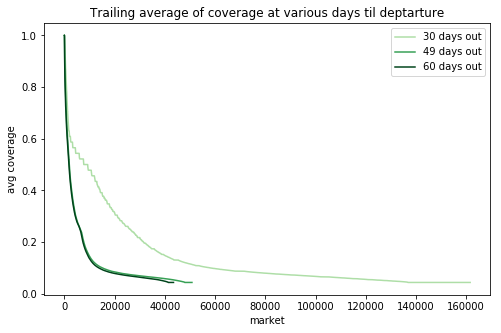

In [35]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf,
                          save_fig=True, filename_extra=f"all-{pos}-markets")

Note how messy this looks

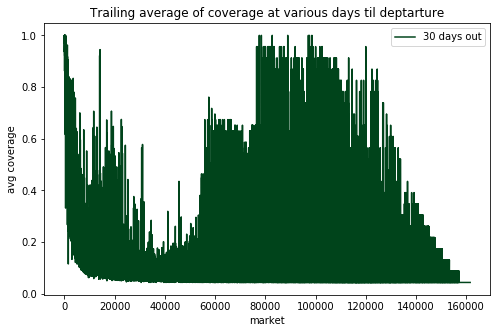

In [36]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, dtd_list=[30], sort_by_vol_only=True)

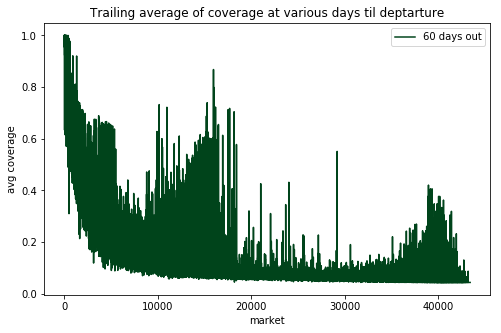

In [37]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, dtd_list=[60], sort_by_vol_only=True)

Restrict to top 10% of markets

28180


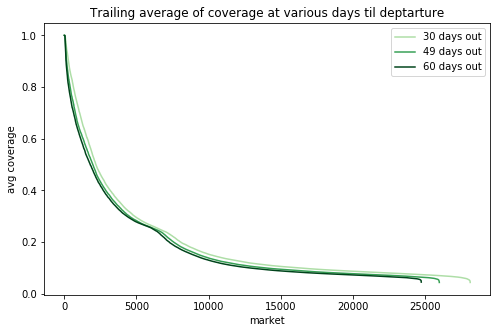

In [38]:
# what is 10%?
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                           save_fig=True, filename_extra=f"top-10pct-markets")

Restrict to top 1000 markets

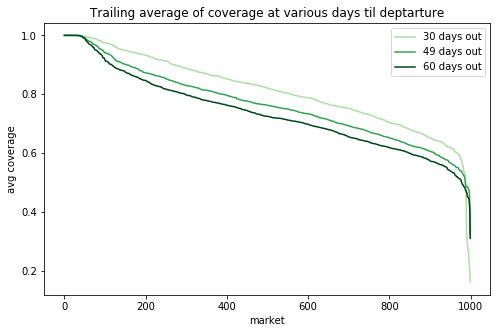

In [39]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=1000, sorted_market_list=markets_by_vol, 
                          save_fig=True, filename_extra=f"top-1000-markets")

In [ ]:
# line_plot_coverage_vs_dtd(pos_cov_summ_pdf, use_color_map=True, top_n=250, sorted_market_list=markets_by_vol)

Note: dips at far right of plots are due to: we select by "top" markets to plot based on volume, but then sort by coverage for each plot. There will almost always be some "top" markets with "poor" coverage

## Optional: Peek at heatmap for various market ranks

In [ ]:
# cov_preproc_df = cov_preproc_df.withColumn("shop_ind", F.lit(1))

In [ ]:
# market = 'LAX-JFK'
# pos = 'US'
# market_df_for_heatmap = process_for_heatmap(market, pos, cov_preproc_df, date_enum_df)

# markets_by_vol.index('JFK-LHR')

# market = 'JFK-LHR'
# pos = 'US'
# market_df_for_heatmap = process_for_heatmap(market, pos, cov_preproc_df, date_enum_df)

# plot_heatmap_single_market(market, market_df_for_heatmap)

# markets_by_vol.index('LAX-EWR')

# market = 'LAX-EWR'
# pos = 'US'
# market_df_for_heatmap = process_for_heatmap(market, pos, cov_preproc_df, date_enum_df)

# plot_heatmap_single_market(market, market_df_for_heatmap)

Look at a market farther down the ranked list

In [ ]:
# markets_by_vol[100:105]

# market = 'ATL-LAS'
# pos = 'US'
# market_df_for_heatmap = process_for_heatmap(market, pos, cov_preproc_df, date_enum_df)
# plot_heatmap_single_market(market, market_df_for_heatmap)

# markets_by_vol[1000:1005]

# market = 'AUS-DEN'
# pos = 'US'
# market_df_for_heatmap = process_for_heatmap(market, pos, cov_preproc_df, date_enum_df)
# plot_heatmap_single_market(market, market_df_for_heatmap)

# template

In [ ]:
pos = "XX"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

In [ ]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all-{pos}-markets")

In [ ]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"all-{pos}-markets")

In [ ]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"all-{pos}-markets")                          

# GB

In [40]:
pos = "GB"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

39724

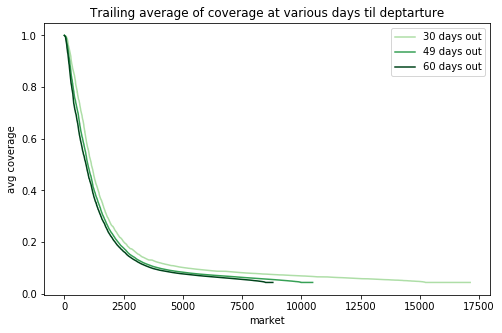

In [41]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all-{pos}-markets")

3972


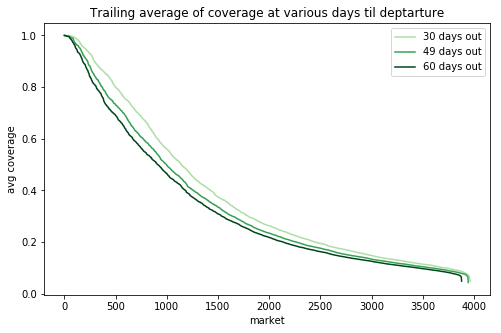

In [42]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"all-{pos}-markets")

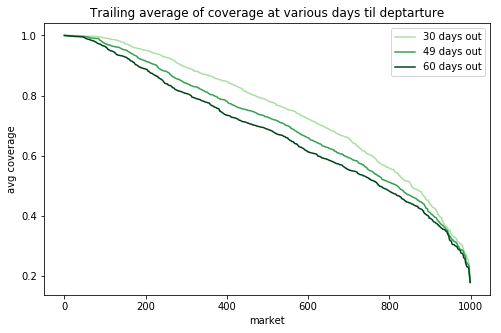

In [43]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"all-{pos}-markets")                          

# IN

In [16]:
pos = "IN"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

31596

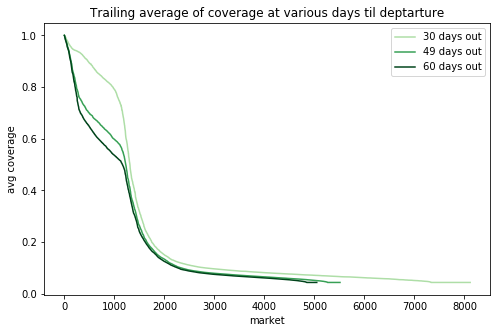

In [17]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all")

3159


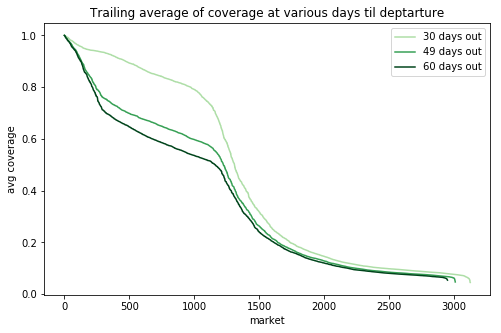

In [18]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top-10pct")

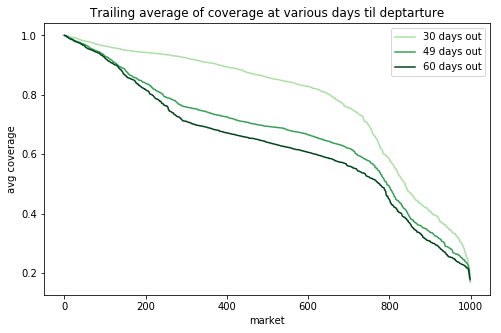

In [19]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top1000")                          

# FR

In [20]:
pos = "FR"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

22895

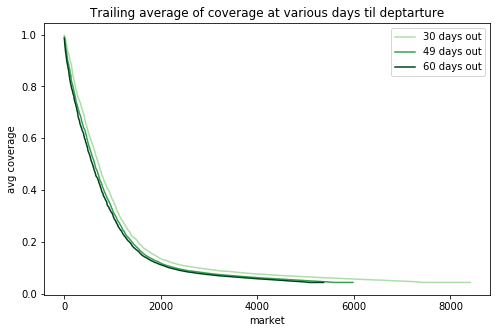

In [21]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all")

2289


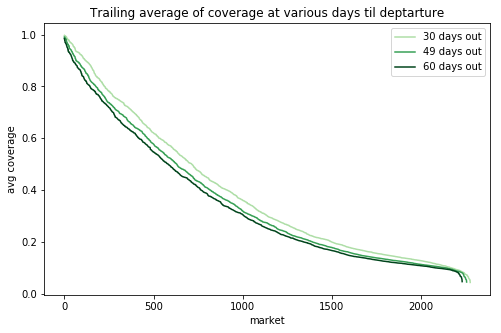

In [22]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top-10pct")

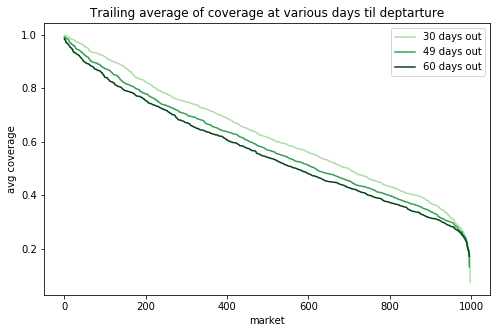

In [23]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top1000")                          

# CA

In [24]:
pos = "CA"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

17598

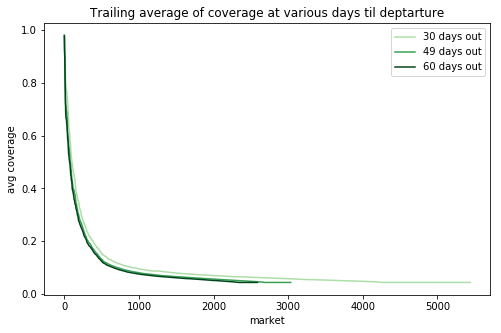

In [25]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all")

1759


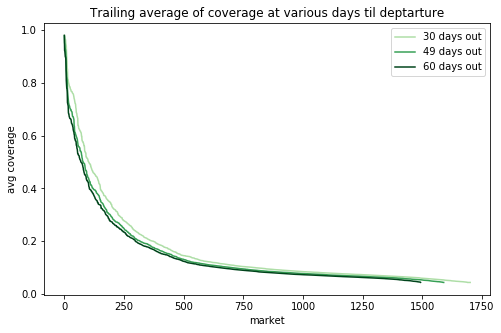

In [26]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top-10pct")

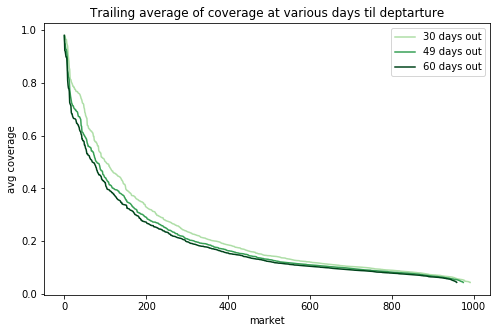

In [27]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top1000")                          

# AU

In [28]:
pos = "AU"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

17110

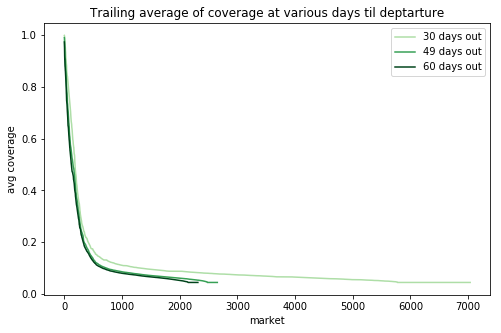

In [29]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all")

1711


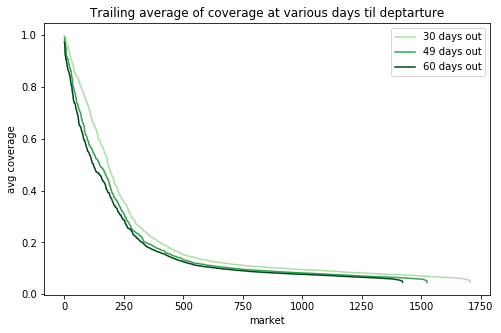

In [30]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top-10pct")

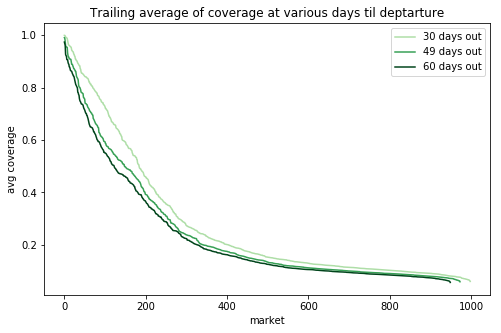

In [31]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top1000")                          

# HK

In [32]:
pos = "HK"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

2312

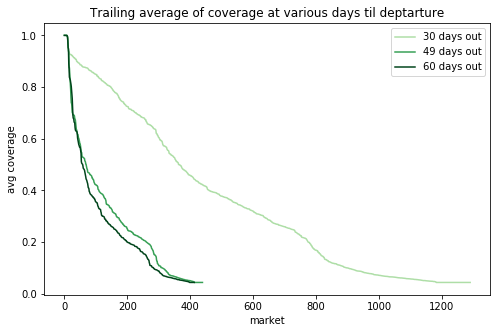

In [33]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all")

231


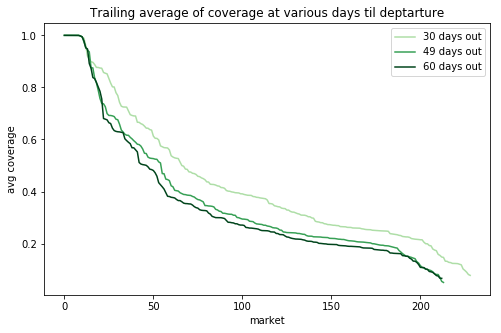

In [34]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top-10pct")

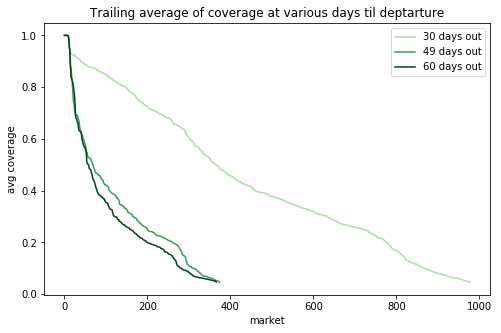

In [35]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top1000")                          

# DE

In [36]:
pos = "DE"
pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
len(markets_by_vol)

29021

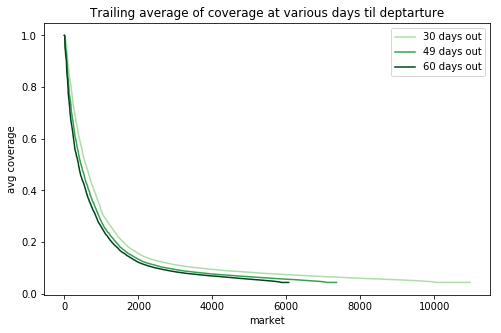

In [37]:
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
                          save_fig=True, filename_extra=f"all")

2902


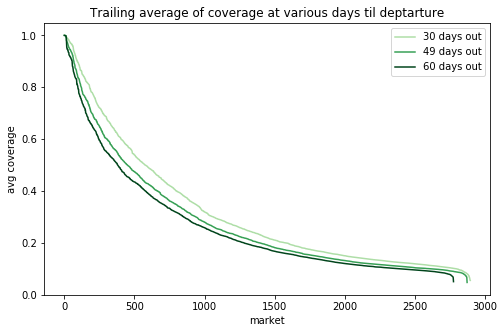

In [38]:
# top 10%
top_10_pct_n = int(len(markets_by_vol) * 0.1)
print(top_10_pct_n)
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top10pct")

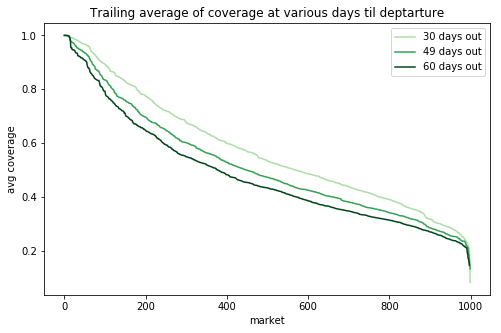

In [39]:
top_n = 1000
line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
                          save_fig=True, filename_extra=f"top1000")                          

# XX

In [40]:
# pos = "xx"
# pos_cov_summ_pdf, pos_df = analyze_pos(cov_preproc_df, pos, los_start, los_end, True)
# markets_by_vol = sort_markets_by_volume(pos_cov_summ_pdf)
# len(markets_by_vol)

# line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, 
#                           save_fig=True, filename_extra=f"all-{pos}-markets")

# # top 10%
# top_10_pct_n = int(len(markets_by_vol) * 0.1)
# print(top_10_pct_n)
# line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_10_pct_n, sorted_market_list=markets_by_vol,
#                           save_fig=True, filename_extra=f"all-{pos}-markets")

# top_n = 1000
# line_plot_coverage_vs_dtd(pos, pos_cov_summ_pdf, top_n=top_n, sorted_market_list=markets_by_vol,
#                           save_fig=True, filename_extra=f"all-{pos}-markets")                          